### Model and Train

In [30]:
import torch
import torch.nn.functional as F 
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GNN(torch.nn.Module):
    def __init__(self, dataset, feature_size):
        super(GNN, self).__init__()
        torch.manual_seed(10)

        input_size = dataset.num_features
        output_size = dataset.num_classes
        self.conv1 = GCNConv(in_channels=input_size, out_channels=feature_size)
        self.conv2 = GCNConv(in_channels=feature_size, out_channels=feature_size)
        self.d1 = torch.nn.Linear(feature_size, output_size)

    def forward(self, x, edge_index):
        # First Message Passing Layer
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.2, training=self.training)

        # Second Message Passing Layer
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.2, training=self.training)

        # Output layer 
        x = F.softmax(self.d1(x), dim=1)
        return x

In [40]:
import collections
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import Data
from tqdm import tqdm
# from model import GNN

class Train():
    def __init__(self, dataset, feature_size, epochs = 10, learning_rate = 0.01):
        self.dataset = dataset
        self.fs = feature_size
        
        self.model = GNN(self.dataset, self.fs)
        self.epochs = epochs
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr = learning_rate)
        self.loss_func = torch.nn.CrossEntropyLoss()
        self.train_network()

    def train_network(self):
        data = self.dataset[0]
        optimizer = self.optimizer
        epochs = self.epochs
        
        train_losses = []
        train_accs = []
        test_losses = []
        test_accs = []

        for epoch in range(epochs + 1):
            optimizer.zero_grad()
            output = self.model(data.x, data.edge_index)
#             output = self.model(data, data.edge_index, data.edge_attr)
            loss = self.loss_func(output[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()
            train_losses += [loss.item()]
            
            train_correct = torch.argmax(output[data.train_mask], dim=1) == data.y[data.train_mask]
            train_acc = int(train_correct.sum()) / int(data.train_mask.sum())
            train_accs += [train_acc]

            test_correct = torch.argmax(output[data.test_mask], dim=1) == data.y[data.test_mask]
            test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
            test_accs += [test_acc]

            print(f"Epoch {epoch + 1}/{epochs}, Train_Loss: {loss:.4f}, Train_Accuracy: {train_acc:.4f}, Test_Accuracy: {test_acc:.4f}")
        print(train_losses)
        print(type(train_losses))
        print(type(train_losses[0]))
        
        plt.plot(train_losses)
        plt.show()

        plt.plot(train_accs)
        plt.plot(test_accs) 
        plt.show()

### Test data

In [41]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [8]:
model = GNN(dataset = dataset, feature_size=16)
print(model)

GNN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 16)
  (d1): Linear(in_features=16, out_features=7, bias=True)
)


Epoch 1/10, Train_Loss: 1.9462, Train_Accuracy: 0.1429, Test_Accuracy: 0.1030
Epoch 2/10, Train_Loss: 1.9459, Train_Accuracy: 0.1429, Test_Accuracy: 0.1030
Epoch 3/10, Train_Loss: 1.9456, Train_Accuracy: 0.1429, Test_Accuracy: 0.1030
Epoch 4/10, Train_Loss: 1.9451, Train_Accuracy: 0.1500, Test_Accuracy: 0.1050
Epoch 5/10, Train_Loss: 1.9445, Train_Accuracy: 0.1786, Test_Accuracy: 0.1300
Epoch 6/10, Train_Loss: 1.9437, Train_Accuracy: 0.2500, Test_Accuracy: 0.1810
Epoch 7/10, Train_Loss: 1.9436, Train_Accuracy: 0.2429, Test_Accuracy: 0.2180
Epoch 8/10, Train_Loss: 1.9419, Train_Accuracy: 0.3214, Test_Accuracy: 0.2840
Epoch 9/10, Train_Loss: 1.9408, Train_Accuracy: 0.2571, Test_Accuracy: 0.3160
Epoch 10/10, Train_Loss: 1.9397, Train_Accuracy: 0.2500, Test_Accuracy: 0.3230
Epoch 11/10, Train_Loss: 1.9377, Train_Accuracy: 0.3000, Test_Accuracy: 0.3370
[1.9462072849273682, 1.9459389448165894, 1.945647120475769, 1.9450585842132568, 1.9445101022720337, 1.9437373876571655, 1.9435629844665527, 

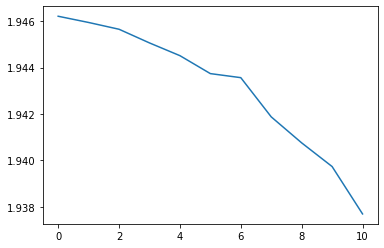

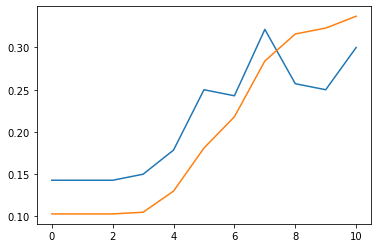

In [42]:
training_result = Train(dataset = dataset, feature_size = 16, epochs = 10, learning_rate = 0.01)